In [1]:
# Import packages and function
import pandas as pd
import polars as pl
#import os
#from datetime import datetime, timedelta
from ppclib import fetch_ppc_data, fetch_ppc_days_back, get_data_profile, combine_ppc_dataframe, blank_svid_ecid, get_parameter, param_spliting, combine

In [2]:
# Fetch PPC data from CIM api
start_date_str = "2025-05-02" # format "YYYY-MM-DD"
daysback = 7
ppc_file_list = fetch_ppc_days_back(start_date_str,daysback)

Skipping 2025-05-02 (file already exists)
Skipping 2025-05-01 (file already exists)
Skipping 2025-04-30 (file already exists)
Skipping 2025-04-29 (file already exists)
Skipping 2025-04-28 (file already exists)
Skipping 2025-04-27 (file already exists)
Skipping 2025-04-26 (file already exists)


In [3]:
# Get list of EquipID and Recipe of the start_date_str
df = pl.read_excel(ppc_file_list[0])
recipe = df['Recipe'].unique()
equipid = df['EquipID'].unique()
equipid = equipid.to_list()
recipe = recipe.to_list()

In [4]:
# Import Data Profile Excel file name 'ProcessParasProfileUTL'
df4 = get_data_profile()

In [5]:
# Consolidate all 'PPCDataUTL' Excel files in working folder to one Polar dataframe
df3 = combine_ppc_dataframe(ppc_file_list)

Appended: D:/ppc_saw/myfolder/2025-05-02.xlsx done.
Schema([('EquipOpn', String), ('EquipID', String), ('ULotID', String), ('Recipe', String), ('Parameter', String), ('CreateTime', Datetime(time_unit='ms', time_zone=None)), ('EventID', String), ('EventDesc', String), ('SAW_ProductionStock_Z1', String), ('BladeOD_Z1', String), ('BladeThickness_Z1', String), ('FlangeODType_Z1', String), ('SAW_ProductionStock_Z2', String), ('BladeOD_Z2', String), ('BladeThickness_Z2', String), ('FlangeODType_Z2', String)])
Appended: D:/ppc_saw/myfolder/2025-05-01.xlsx done.
Schema([('EquipOpn', String), ('EquipID', String), ('ULotID', String), ('Recipe', String), ('Parameter', String), ('CreateTime', Datetime(time_unit='ms', time_zone=None)), ('EventID', String), ('EventDesc', String), ('SAW_ProductionStock_Z1', String), ('BladeOD_Z1', String), ('BladeThickness_Z1', String), ('FlangeODType_Z1', String), ('SAW_ProductionStock_Z2', String), ('BladeOD_Z2', String), ('BladeThickness_Z2', String), ('FlangeODTy

In [6]:
# Extract the parameters string from the 'parameter' column df3 to SVID and ECID dataframe
df3,SVID,ECID = param_spliting(df3)

Processing rows: 1500678it [00:22, 66927.00it/s]


In [7]:
# Memory release 
svid_rows = []
ecid_rows = []

In [8]:
# Join df3, SVID and ECID dataframe and combine to result polar dataframe
result = combine(df3,SVID,ECID)


In [9]:
# Anomaly Detection with Isolation Forest Code on result dataframe
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Initial cleaning
dfx = result.dropna(axis=1, how='all')          # Drop completely empty columns
dfx = dfx.dropna(axis=0, how='any')              # Drop rows with any missing values
df = dfx.drop(['CreateTime', 'CreateTimeUnix'], axis=1)  # Remove time columns

# Free Memory
result = []

# Preserve original categorical values before encoding
original_cat_columns = df.select_dtypes(include='object').copy()
encoded_df = df.copy()

# Label encode categorical columns
cat_cols = original_cat_columns.columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le

# Train Isolation Forest and get scores
model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
model.fit(encoded_df)

# Get anomaly scores and normalize them to 0-1 range
scores = model.decision_function(encoded_df)
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores.reshape(-1, 1))

# Create results dataframe with original values and scores
encoded_df['AnomalyScore'] = scores  # Original scores (-0.5 to 0.5)
encoded_df['AnomalyScore_normalized'] = normalized_scores  # 0-1 scaled

results_df = pd.concat([
    encoded_df[['AnomalyScore', 'AnomalyScore_normalized']],
    dfx[['CreateTime','CreateTimeUnix']], original_cat_columns,
    df.select_dtypes(exclude='object')
], axis=1)

# Sort by anomaly score for better inspection
#results_df = results_df.sort_values('AnomalyScore_normalized', ascending=False)

# Extract anomalies with original values
anomalies_df = results_df[results_df['AnomalyScore_normalized'] > 0.5]  # Adjust threshold as needed
#print(f"Found {len(anomalies_df)} anomalies from {len(df)} total records")
#print("\nTop 5 anomalies:")
#print(anomalies_df.head())

# Verification metrics
print("\nScore Statistics:")
print(f"Mean score: {results_df.AnomalyScore_normalized.mean():.2f}")
print(f"Max score: {results_df.AnomalyScore_normalized.max():.2f}")
print(f"Min score: {results_df.AnomalyScore_normalized.min():.2f}")


Score Statistics:
Mean score: 0.77
Max score: 1.00
Min score: 0.00


In [10]:
results_df

,AnomalyScore,AnomalyScore_normalized,CreateTime,CreateTimeUnix,EquipID,Recipe,EventDesc,SAW_ProductionStock_Z1,BladeOD_Z1,BladeThickness_Z1,...,SVID_1503,SVID_1760,SVID_1759,SVID_1755,SVID_1756,SVID_1500,SVID_1501,SVID_1785,SVID_1764,SVID_1766
7230,0.111711,0.859992,2025-04-26 00:01:53.653,1745625713,TSWD038,ADI4623P_E,Kerf Check Start,SW00000057,2.1874,0.001,...,580,131,202,134,207,44960,29970,201,44990,29960
7231,0.090993,0.786812,2025-04-26 00:02:03.690,1745625723,TSWD038,ADI4623P_E,Kerf Check End,SW00000057,2.1874,0.001,...,580,131,201,140,210,44990,29960,210,44990,29970
7232,0.098012,0.811603,2025-04-26 00:03:21.390,1745625801,TSWD038,ADI4623P_E,Kerf Check Start,SW00000057,2.1874,0.001,...,620,131,202,136,205,44960,29970,208,44990,29970
7233,0.064740,0.694081,2025-04-26 00:03:27.460,1745625807,TSWD038,ADI4623P_E,Kerf Check End,SW00000057,2.1874,0.001,...,1110,131,202,139,203,44990,29950,212,44960,29970
7234,0.083271,0.759536,2025-04-26 00:04:43.020,1745625883,TSWD038,ADI4623P_E,Kerf Check Start,SW00000057,2.1874,0.001,...,560,131,202,128,199,44990,29970,205,44990,29970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676196,0.034705,0.587994,2025-04-30 09:25:22.057,1746005122,TSWD299,VS00014P_Q_3,Kerf Check End,SW00000165,2.1874,0.00118,...,1060,208,205,135,206,45000,40000,201,44960,39960
676197,0.082540,0.756954,2025-04-30 09:28:36.130,1746005316,TSWD299,VS00014P_Q_3,Kerf Check Start,SW00000165,2.1874,0.00118,...,710,207,205,135,206,45000,40000,201,45000,40000
676198,0.035259,0.589952,2025-04-30 09:28:48.653,1746005328,TSWD299,VS00014P_Q_3,Kerf Check End,SW00000165,2.1874,0.00118,...,1110,207,206,135,206,44960,40000,202,45000,40000
676199,0.030463,0.573013,2025-04-30 09:32:05.350,1746005525,TSWD299,VS00014P_Q_3,Kerf Check End,SW00000165,2.1874,0.00118,...,1150,207,206,135,206,44920,39960,201,45000,40000


In [11]:
# anomalies_df.info()
anomalies_df.to_csv('anomaly_output.csv', index=False)

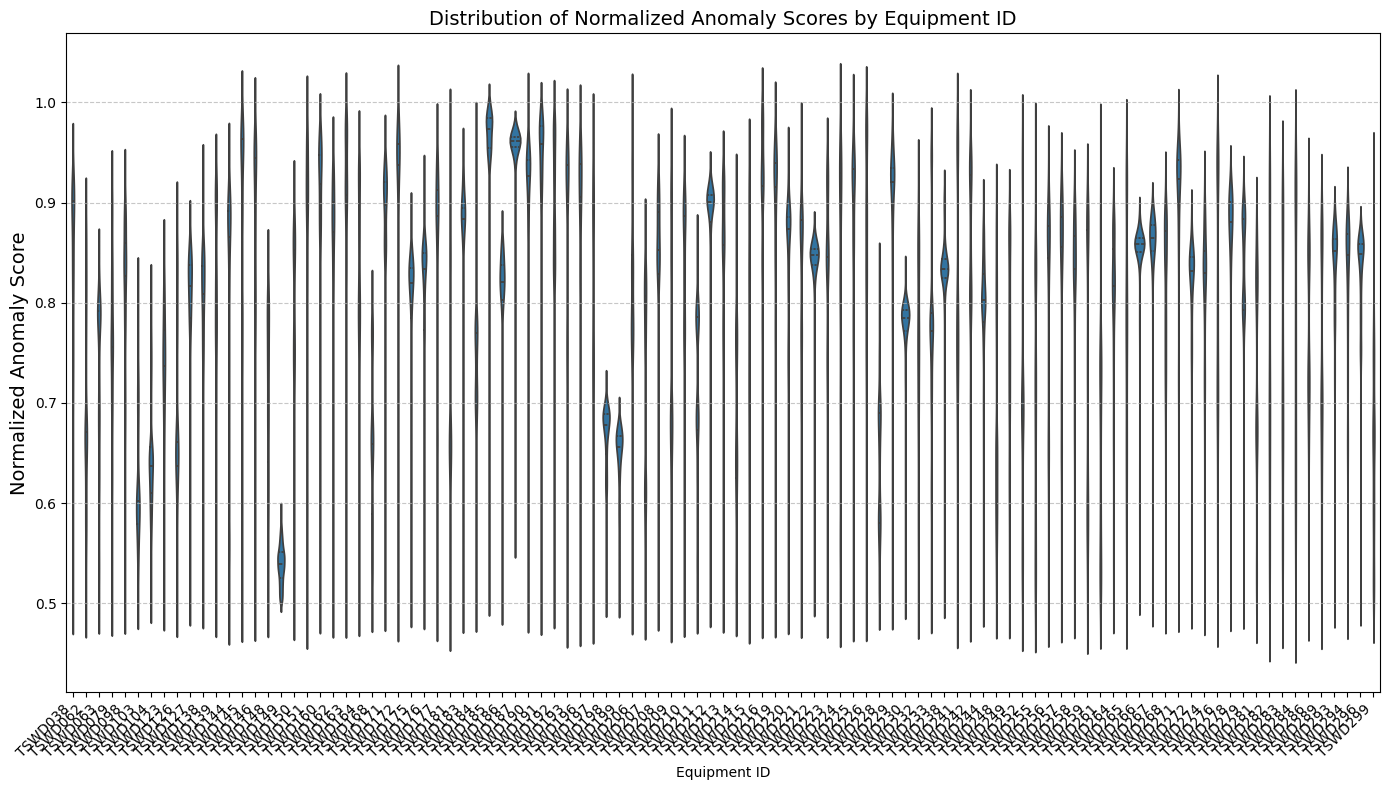

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style and size
plt.figure(figsize=(14, 8))

# Create violin plot (shows distribution density)
sns.violinplot(
    x='EquipID',
    y='AnomalyScore_normalized',
    data=anomalies_df,
    inner='quartile'  # Adds quartile lines inside the violin
)

# Improve readability
plt.title('Distribution of Normalized Anomaly Scores by Equipment ID', fontsize=14)
plt.xlabel('Equipment ID', fontsize=10)
plt.ylabel('Normalized Anomaly Score', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Add gridlines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [13]:
dfx.head(3)

,EquipID,Recipe,CreateTime,CreateTimeUnix,EventDesc,SAW_ProductionStock_Z1,BladeOD_Z1,BladeThickness_Z1,FlangeODType_Z1,SAW_ProductionStock_Z2,...,SVID_1503,SVID_1760,SVID_1759,SVID_1755,SVID_1756,SVID_1500,SVID_1501,SVID_1785,SVID_1764,SVID_1766
7230,TSWD038,ADI4623P_E,2025-04-26 00:01:53.653,1745625713,Kerf Check Start,SW00000057,2.1874,0.001,Hub,SW00000067,...,580,131,202,134,207,44960,29970,201,44990,29960
7231,TSWD038,ADI4623P_E,2025-04-26 00:02:03.690,1745625723,Kerf Check End,SW00000057,2.1874,0.001,Hub,SW00000067,...,580,131,201,140,210,44990,29960,210,44990,29970
7232,TSWD038,ADI4623P_E,2025-04-26 00:03:21.390,1745625801,Kerf Check Start,SW00000057,2.1874,0.001,Hub,SW00000067,...,620,131,202,136,205,44960,29970,208,44990,29970


In [14]:
anomalies_df.head(3)

,AnomalyScore,AnomalyScore_normalized,CreateTime,CreateTimeUnix,EquipID,Recipe,EventDesc,SAW_ProductionStock_Z1,BladeOD_Z1,BladeThickness_Z1,...,SVID_1503,SVID_1760,SVID_1759,SVID_1755,SVID_1756,SVID_1500,SVID_1501,SVID_1785,SVID_1764,SVID_1766
7230,0.111711,0.859992,2025-04-26 00:01:53.653,1745625713,TSWD038,ADI4623P_E,Kerf Check Start,SW00000057,2.1874,0.001,...,580,131,202,134,207,44960,29970,201,44990,29960
7231,0.090993,0.786812,2025-04-26 00:02:03.690,1745625723,TSWD038,ADI4623P_E,Kerf Check End,SW00000057,2.1874,0.001,...,580,131,201,140,210,44990,29960,210,44990,29970
7232,0.098012,0.811603,2025-04-26 00:03:21.390,1745625801,TSWD038,ADI4623P_E,Kerf Check Start,SW00000057,2.1874,0.001,...,620,131,202,136,205,44960,29970,208,44990,29970


In [15]:
anomalies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514725 entries, 7230 to 676200
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   AnomalyScore             514725 non-null  float64       
 1   AnomalyScore_normalized  514725 non-null  float64       
 2   CreateTime               514725 non-null  datetime64[ms]
 3   CreateTimeUnix           514725 non-null  int64         
 4   EquipID                  514725 non-null  object        
 5   Recipe                   514725 non-null  object        
 6   EventDesc                514725 non-null  object        
 7   SAW_ProductionStock_Z1   514725 non-null  object        
 8   BladeOD_Z1               514725 non-null  object        
 9   BladeThickness_Z1        514725 non-null  object        
 10  FlangeODType_Z1          514725 non-null  object        
 11  SAW_ProductionStock_Z2   514725 non-null  object        
 12  BladeOD_Z2        

In [16]:
# Select the columns of interest
cols_to_analyze = ['Recipe', 'EventDesc', 'SAW_ProductionStock_Z1', 'BladeThickness_Z1']

C:\Users\User\AppData\Local\Temp\ipykernel_21744\8941602.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\User\AppData\Local\Temp\ipykernel_21744\8941602.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\User\AppData\Local\Temp\ipykernel_21744\8941602.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\User\AppData\Local\Temp\ipykernel_21744\8941602.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set

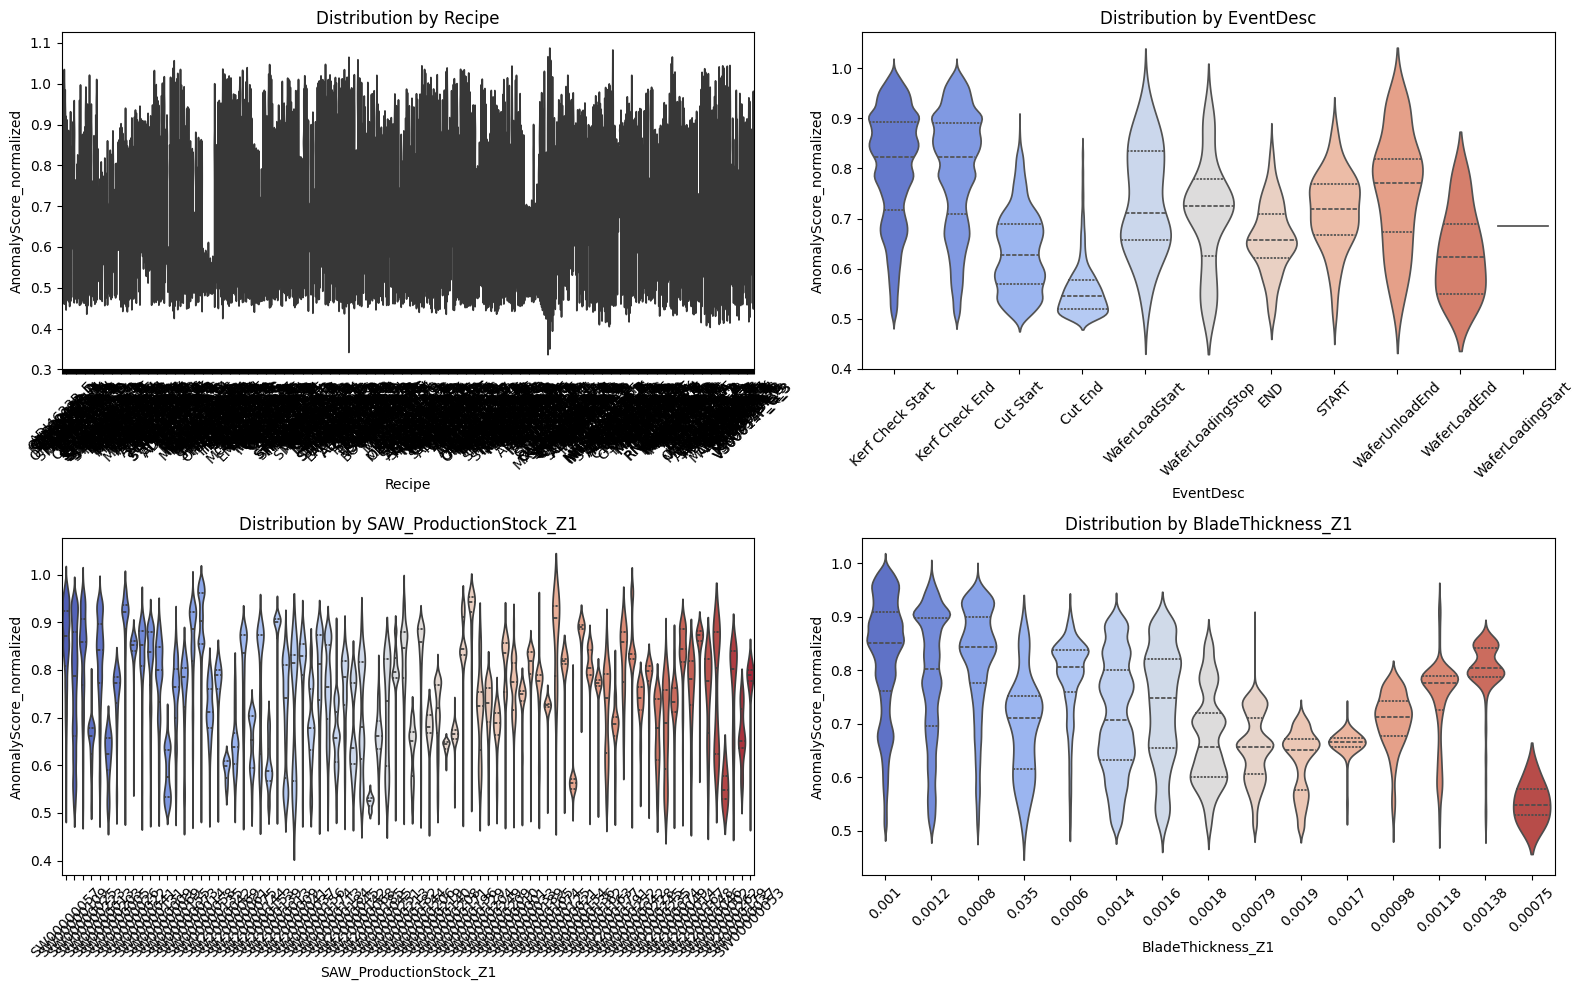

In [17]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(cols_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(
        data=anomalies_df,
        x=col,
        y='AnomalyScore_normalized',
        palette='coolwarm',
        inner='quartile'  # Show median and quartiles
    )
    plt.title(f'Distribution by {col}', fontsize=12)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

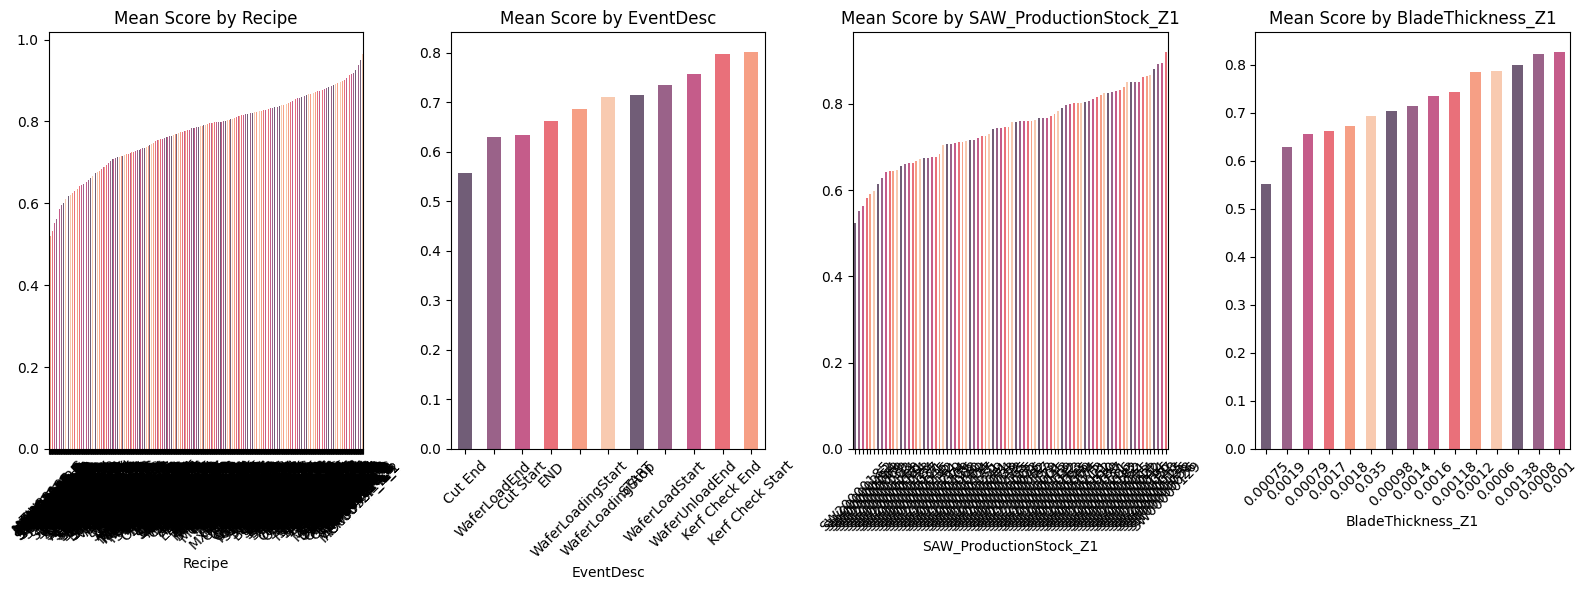

In [18]:
plt.figure(figsize=(16, 6))

# Calculate mean anomaly score by category for each column
for i, col in enumerate(cols_to_analyze, 1):
    plt.subplot(1, 4, i)
    anomalies_df.groupby(col)['AnomalyScore_normalized'].mean().sort_values().plot(
        kind='bar',
        color=sns.color_palette('rocket'),
        alpha=0.7
    )
    plt.title(f'Mean Score by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

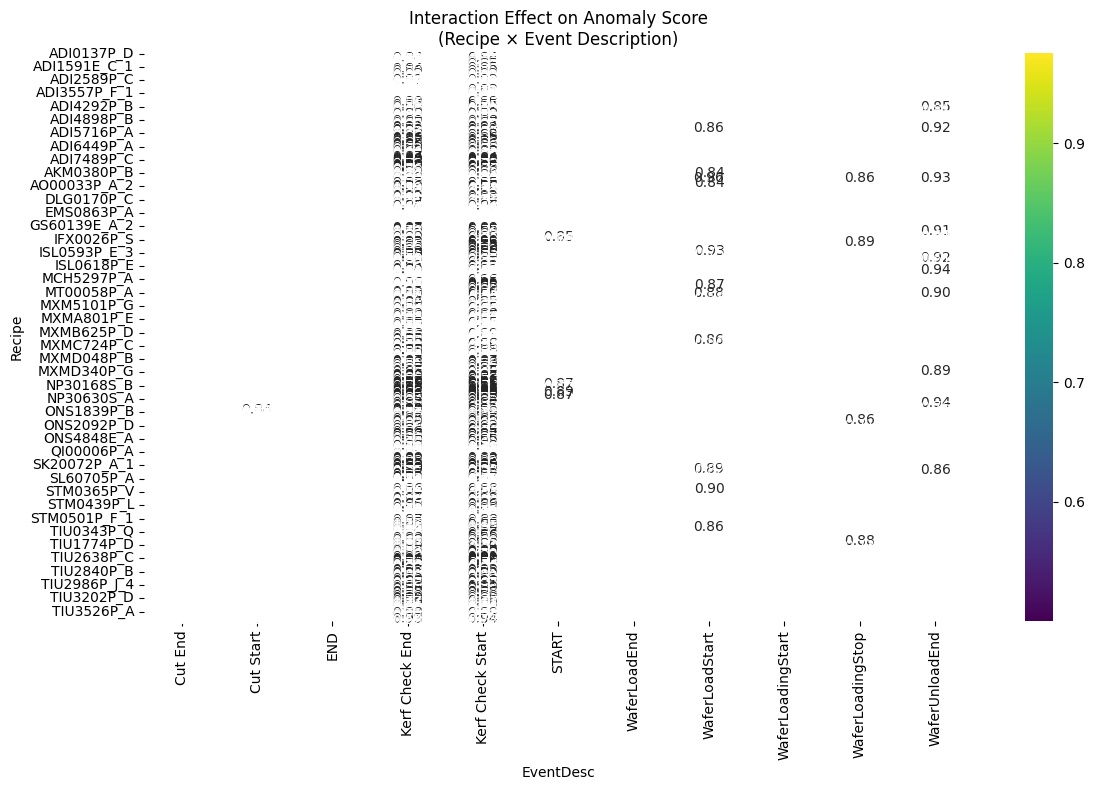

In [19]:
# Create a pivot table of mean scores
heatmap_data = pd.pivot_table(
    data=anomalies_df,
    index='Recipe',  # Primary category
    columns='EventDesc',  # Secondary category
    values='AnomalyScore_normalized',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title('Interaction Effect on Anomaly Score\n(Recipe × Event Description)')
plt.tight_layout()
plt.show()

In [20]:
equipid

['TSWD219',
 'TSWD225',
 'TSWD190',
 'TSWD181',
 'TSWD258',
 'TSWD215',
 'TSWD199',
 'TSWD210',
 'TSWD193',
 'TSWD274',
 'TSWD138',
 'TSWD172',
 'TSWD139',
 'TSWD059',
 'TSWD126',
 'TSWD110',
 'TSWD284',
 'TSWD109',
 'TSWD283',
 'TSWD063',
 'TSWD146',
 'TSWD279',
 'TSWD233',
 'TSWD127',
 'TSWD069',
 'TSWD221',
 'TSWD144',
 'TSWD131',
 'TSWD036',
 'TSWD145',
 'TSWD208',
 'TSWD100',
 'TSWD286',
 'TSWD271',
 'TSWD187',
 'TSWD257',
 'TSWD060',
 'TSWD216',
 'TSWD213',
 'TSWD207',
 'TSWD222',
 'TSWD150',
 'TSWD264',
 'TSWD252',
 'TSWD255',
 'TSWD209',
 'TSWD132',
 'TSWD104',
 'TSWD256',
 'TSWD296',
 'TSWD265',
 'TSWD122',
 'TSWD051',
 'TSWD183',
 'TSWD148',
 'TSWD212',
 'TSWD214',
 'TSWD123',
 'TSWD228',
 'TSWD197',
 'TSWD267',
 'TSWD052',
 'TSWD272',
 'TSWD103',
 'TSWD175',
 'TSWD065',
 'TSWD105',
 'TSWD186',
 'TSWD192',
 'TSWD282',
 'TSWD268',
 'TSWD276',
 'TSWD248',
 'TSWD281',
 'TSWD294',
 'TSWD278',
 'TSWD244',
 'TSWD038',
 'TSWD226',
 'TSWD163',
 'TSWD196',
 'TSWD289',
 'TSWD056',
 'TS